In [1]:
import sys
import random
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import sumolib
import traci
from sumolib import checkBinary
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv, JumpingKnowledge
from torch_geometric.data import Data, Batch
import sys
import io
from contextlib import redirect_stdout
import matplotlib.pyplot as plt
import pandas as pd
import os
import math
from collections import namedtuple, deque
import gym
from torch_geometric.utils import dense_to_sparse
import copy
from itertools import count

if 'SUMO_HOME' in os.environ:
    print('SUMO_HOME found')
    sys.path.append(os.path.join(os.environ['SUMO_HOME'], 'tools'))

# sumoBinary = checkBinary('sumo-gui')
sumoBinary = checkBinary('sumo')
roadNetwork = "./config/osm.sumocfg"
sumoCmd = [sumoBinary, "-c", roadNetwork, "--start", "--quit-on-end"]
# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print("Using device: " + str(device))

SUMO_HOME found
Using device: cuda


In [2]:
def intervehicleConnectivity(threshold = None):
    xs = []
    ys = []
    for vehicle in traci.vehicle.getIDList():
        x, y = traci.vehicle.getPosition(vehicle)
        xs.append(x)
        ys.append(y)
    xs = torch.tensor(xs, dtype=torch.float32).view(-1,1)
    ys = torch.tensor(ys, dtype=torch.float32).view(-1,1)
    intervehicle_distances = torch.sqrt((xs - xs.t())**2 + (ys - ys.t())**2)
    if threshold is not None:
        # make the distances 1 if less than the threshold, 0 otherwise
        connectivity = torch.where(intervehicle_distances < threshold, torch.ones_like(intervehicle_distances), torch.zeros_like(intervehicle_distances))
    return connectivity, xs, ys

In [3]:
def randomTrips(dur=1000, density=12):
    os.system("python $SUMO_HOME/tools/randomTrips.py -n config/osm.net.xml.gz -r config/osm.passenger.trips.xml -e " + str(dur) + " -l --insertion-density=" + str(density))

def shouldContinueSim():
    numVehicles = traci.simulation.getMinExpectedNumber()
    return True if numVehicles > 0 else False

def restart(sumoCmd):
    with io.StringIO() as buf, redirect_stdout(buf):
        try:
            traci.close()
        except:
            pass
        traci.start(sumoCmd)

def close():
    traci.close()

# randomTrips(800, 1.5)

In [4]:
def simplify_graph(adj_matrix):
    adj_matrix = adj_matrix - torch.eye(adj_matrix.size(0))
    degrees = torch.sum(adj_matrix, axis=0)
    nodes_to_keep = np.where(degrees > 0)[0]
    new_adj_matrix = adj_matrix[np.ix_(nodes_to_keep, nodes_to_keep)]
    return new_adj_matrix

def bfs_distance(adj_matrix):
    n_hop_matrix = torch.ones_like(adj_matrix) * (-100)
    for start_node in range(adj_matrix.size(0)):
        visited = [0] * adj_matrix.size(0)
        queue = deque([(start_node, 0)])
        visited[start_node] = True
        
        while queue:
            current_node, current_dist = queue.popleft()
            
            for neighbor, connected in enumerate(adj_matrix[current_node]):
                if connected and not visited[neighbor]:
                    queue.append((neighbor, current_dist + 1))
                    visited[neighbor] = True
                    n_hop_matrix[start_node, neighbor] = current_dist + 1

    return n_hop_matrix

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CrossAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(CrossAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.head_dim = d_model // num_heads
        
        # Make sure that the d_model is divisible by the number of heads
        assert self.head_dim * num_heads == d_model
        
        self.query_linear = nn.Linear(d_model, d_model)
        self.key_linear = nn.Linear(d_model, d_model)
        self.value_linear = nn.Linear(d_model, d_model)
        self.out_linear = nn.Linear(d_model, d_model)
        
    def forward(self, query, key, value):
        batch_size = query.size(0)

        Q = self.query_linear(query)  # (batch_size, seq_len, d_model)
        K = self.key_linear(key)      # (batch_size, seq_len, d_model)
        V = self.value_linear(value)  # (batch_size, seq_len, d_model)
        
        # Reshape and transpose for multi-head attention
        Q = Q.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        
        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)
        
        attn_weights = F.softmax(scores, dim=-1)
        
        # Weighted sum
        attn_output = torch.matmul(attn_weights, V)
        
        # Concatenate heads and put through final linear layer
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        output = self.out_linear(attn_output)
        
        return output

In [6]:
Transition = namedtuple('Transition',
                        ('data', 'action', 'next_state', 'reward', 'shuffle_indices'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


In [7]:
class GDQN_Attention(nn.Module):
    def __init__(self, in_channels=13, n_nodes=55, hidden_dim=32, max_n_neighbors=6, num_layers=5):
        super(GDQN_Attention, self).__init__()
        self.n_nodes = n_nodes
        self.hidden_dim = hidden_dim
        self.convs1 = GCNConv(in_channels, hidden_dim)
        self.convs2 = GCNConv(hidden_dim, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim * max_n_neighbors, max_n_neighbors)
        self.selu = nn.SELU()
        self.cross_attn = CrossAttention(hidden_dim, 1)
        self.max_n_neighbors = max_n_neighbors

    def forward(self, data, shuffle_indices=None):
        x, edge_index = data.x, data.edge_index
        batch_neighbor_mask = x[:, -3].reshape(-1, self.n_nodes)
        x = self.convs1(x, edge_index)
        x = self.selu(x)
        x = self.convs2(x, edge_index)
        x = self.selu(x)

        keys = x.reshape(-1, self.n_nodes, self.hidden_dim)
        values = x.reshape(-1, self.n_nodes, self.hidden_dim)
        batch_size = keys.size(0)
        querys = []
        for i in range(batch_size):
            neighbor_indices = torch.where(batch_neighbor_mask[i])
            query = keys[i][neighbor_indices]
            if query.size(0) < self.max_n_neighbors:
                query = F.pad(query, (0, 0, 0, self.max_n_neighbors - query.size(0)), "constant", 0)
            querys.append(query)
        querys = torch.stack(querys)

        if batch_size == 1:
            shuffle_indices = shuffle_indices.unsqueeze(0)
        if shuffle_indices is not None:
            batch_indices = torch.arange(batch_size).unsqueeze(1).expand(-1, shuffle_indices.size(1))
            shuffled_query = querys[batch_indices, shuffle_indices]
        else:
            shuffled_query = querys
        x = self.cross_attn(shuffled_query, keys, values)
        x = x.reshape(-1, self.hidden_dim * self.max_n_neighbors)
        x = self.selu(x)
        x = self.fc1(x)
        return x

In [8]:
class SAGE_GDQN_Attention(nn.Module):
    def __init__(self, in_channels=13, n_nodes=55, hidden_dim=32, max_n_neighbors=6, num_layers=5):
        super(SAGE_GDQN_Attention, self).__init__()
        self.n_nodes = n_nodes
        self.hidden_dim = hidden_dim
        self.convs1 = SAGEConv(in_channels, hidden_dim)
        self.convs2 = SAGEConv(hidden_dim, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim * max_n_neighbors, max_n_neighbors)
        self.selu = nn.SELU()
        self.cross_attn = CrossAttention(hidden_dim, 1)
        self.max_n_neighbors = max_n_neighbors

    def forward(self, data, shuffle_indices=None):
        x, edge_index = data.x, data.edge_index
        batch_neighbor_mask = x[:, -3].reshape(-1, self.n_nodes)
        x = self.convs1(x, edge_index)
        x = self.selu(x)
        x = self.convs2(x, edge_index)
        x = self.selu(x)

        keys = x.reshape(-1, self.n_nodes, self.hidden_dim)
        values = x.reshape(-1, self.n_nodes, self.hidden_dim)
        batch_size = keys.size(0)
        querys = []
        for i in range(batch_size):
            neighbor_indices = torch.where(batch_neighbor_mask[i])
            query = keys[i][neighbor_indices]
            if query.size(0) < self.max_n_neighbors:
                query = F.pad(query, (0, 0, 0, self.max_n_neighbors - query.size(0)), "constant", 0)
            querys.append(query)
        querys = torch.stack(querys)

        if batch_size == 1:
            shuffle_indices = shuffle_indices.unsqueeze(0)
        if shuffle_indices is not None:
            batch_indices = torch.arange(batch_size).unsqueeze(1).expand(-1, shuffle_indices.size(1))
            shuffled_query = querys[batch_indices, shuffle_indices]
        else:
            shuffled_query = querys
        x = self.cross_attn(shuffled_query, keys, values)
        x = x.reshape(-1, self.hidden_dim * self.max_n_neighbors)
        x = self.selu(x)
        x = self.fc1(x)
        return x

In [9]:
class JK_SAGE_GDQN_Attention(nn.Module):
    def __init__(self, in_channels=13, n_nodes=55, hidden_dim=32, max_n_neighbors=6, num_layers=5):
        super(JK_SAGE_GDQN_Attention, self).__init__()
        self.n_nodes = n_nodes
        self.hidden_dim = hidden_dim
        self.convs = nn.ModuleList([SAGEConv(in_channels if i == 0 else hidden_dim, hidden_dim) for i in range(num_layers)])
        self.jk = JumpingKnowledge('max', num_layers=num_layers, channels=hidden_dim)
        self.fc1 = nn.Linear(hidden_dim * max_n_neighbors, max_n_neighbors)
        self.selu = nn.SELU()
        self.cross_attn = CrossAttention(hidden_dim, 1)
        self.max_n_neighbors = max_n_neighbors

    def forward(self, data, shuffle_indices=None):
        x, edge_index = data.x, data.edge_index
        batch_neighbor_mask = x[:, -3].reshape(-1, self.n_nodes)
        xs = []
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.selu(x)
            xs.append(x)
        x = self.jk(xs)
        x = self.selu(x)

        keys = x.reshape(-1, self.n_nodes, self.hidden_dim)
        values = x.reshape(-1, self.n_nodes, self.hidden_dim)
        batch_size = keys.size(0)
        querys = []
        for i in range(batch_size):
            neighbor_indices = torch.where(batch_neighbor_mask[i])
            query = keys[i][neighbor_indices]
            if query.size(0) < self.max_n_neighbors:
                query = F.pad(query, (0, 0, 0, self.max_n_neighbors - query.size(0)), "constant", 0)
            querys.append(query)
        querys = torch.stack(querys)

        if batch_size == 1:
            shuffle_indices = shuffle_indices.unsqueeze(0)
        if shuffle_indices is not None:
            batch_indices = torch.arange(batch_size).unsqueeze(1).expand(-1, shuffle_indices.size(1))
            shuffled_query = querys[batch_indices, shuffle_indices]
        else:
            shuffled_query = querys
        x = self.cross_attn(shuffled_query, keys, values)
        x = x.reshape(-1, self.hidden_dim * self.max_n_neighbors)
        x = self.selu(x)
        x = self.fc1(x)
        return x

In [10]:
class RoutingGym(gym.Env):
    def __init__(self, sumoCmd, max_steps=1100, n_nodes=57, max_routing_steps=30, max_n_neighbors=6):
        self.sumoCmd = sumoCmd
        self.step_counter = 0
        self.max_steps = max_steps
        self.n_nodes = n_nodes
        self.start_node = None
        self.end_node = None
        self.current_node = None
        self.node_features = None
        self.adj_matrix = None
        self.edge_index = None
        self.hop_thresh = None
        self.routing_done = False
        self.routing_steps = 0
        self.min_n_hops = None
        self.end_node_indicator = torch.zeros(n_nodes)
        self.max_routing_steps = max_routing_steps
        self.n_hop_matrix = None
        self.neighbors_indicator = None
        self.action_space = None
        self.to_remove_indices = None
        self.prunned_adj_matrix = None
        self.prunned_n_hop_matrix = None
        self.state = None
        self.max_n_neighbors = max_n_neighbors

        self.xs = None
        self.ys = None
        self.norm_x = None
        self.norm_y = None

    def reset(self):
        try:
            traci.close()
        except:
            pass
        traci.start(sumoCmd)
        self.step_counter = 0

        while self.step_counter < 400:
            traci.simulationStep()
            self.step_counter += 1

    def node_pruning(self):
        self.prunned_adj_matrix = copy.deepcopy(self.adj_matrix)
        self.prunned_n_hop_matrix = copy.deepcopy(self.n_hop_matrix)
        neighbor_indices = np.where(self.adj_matrix[self.current_node] == 1)[0]
        if len(neighbor_indices) >= self.max_n_neighbors:
            two_hop_neighbours_indices = np.where(self.n_hop_matrix[self.current_node] == 2)[0]
            two_hop_neighbours_mask = (self.n_hop_matrix[self.current_node] == 2).type(torch.int)
            # direct neighbours connectivities with two hop neighbours
            neighbour_dict = {}
            for neighbour_index in neighbor_indices:
                neighbour_dict[neighbour_index] = two_hop_neighbours_indices[np.where(self.adj_matrix[neighbour_index][two_hop_neighbours_indices] == 1)[0]]
            # sort by the number of two hop neighbours
            neighbour_dict = dict(sorted(neighbour_dict.items(), key=lambda item: len(item[1]), reverse=True))

            self.to_remove_indices = []
            action_space = 0
            for neighbour_index, two_hop_neighbours_indices in neighbour_dict.items():
                mask_sum_before = torch.sum(two_hop_neighbours_mask)
                two_hop_neighbours_mask[two_hop_neighbours_indices] = 0
                mask_sum_after = torch.sum(two_hop_neighbours_mask)
                if mask_sum_after < mask_sum_before:
                    action_space += 1
                else:
                    self.to_remove_indices.append(neighbour_index)
            if action_space < self.max_n_neighbors:
                self.to_remove_indices = random.sample(self.to_remove_indices, len(self.to_remove_indices) - (self.max_n_neighbors - action_space))
            self.prunned_adj_matrix[self.to_remove_indices, :] = 0
            self.prunned_adj_matrix[:, self.to_remove_indices] = 0
            self.prunned_n_hop_matrix[self.to_remove_indices, :] = 0
            self.prunned_n_hop_matrix[:, self.to_remove_indices] = 0

    def step(self):
        traci.simulationStep()
        self.routing_done = False
        self.routing_steps = 0
        self.step_counter += 1
        self.adj_matrix, self.xs, self.ys = intervehicleConnectivity(800)
        self.adj_matrix = simplify_graph(self.adj_matrix)
        self.select_start_end_nodes()
        self.current_node = self.start_node
        self.adj_matrix = F.pad(self.adj_matrix, (0, self.n_nodes - self.adj_matrix.size(0), 
                                                  0, self.n_nodes - self.adj_matrix.size(1)), "constant", 0)
        self.n_hop_matrix = F.pad(self.n_hop_matrix, (0, self.n_nodes - self.n_hop_matrix.size(0), 
                                                      0, self.n_nodes - self.n_hop_matrix.size(1)), "constant", -100)
        self.node_pruning()
        # set diagonal to 0
        self.prunned_n_hop_matrix = self.prunned_n_hop_matrix - torch.diag(torch.diag(self.prunned_n_hop_matrix))
        curr_node_indicator = torch.zeros(self.n_nodes)
        curr_node_indicator[self.current_node] = 1
        self.end_node_indicator = self.prunned_adj_matrix[self.end_node]
        distances = self.prunned_n_hop_matrix[self.current_node]
        distances[distances == -100] = 8
        distances[distances > 7] = 7
        one_hot_distances = F.one_hot(distances.long(), num_classes=8).type(torch.float32)
        neighbour_indicator = self.prunned_adj_matrix[self.current_node]
        self.node_features = torch.cat((one_hot_distances, self.end_node_indicator.unsqueeze(1), 
                                        curr_node_indicator.unsqueeze(1), neighbour_indicator.unsqueeze(1), 
                                        self.norm_x, self.norm_y), dim=1).to(device)
        self.state = Data(x=self.node_features, edge_index=self.get_edge_index())
        return self.state
    
    def refresh(self):
        self.select_start_end_nodes(True)
        self.routing_done = False
        self.routing_steps = 0
        self.current_node = self.start_node
        self.node_pruning()
        self.prunned_n_hop_matrix = self.prunned_n_hop_matrix - torch.diag(torch.diag(self.prunned_n_hop_matrix))
        curr_node_indicator = torch.zeros(self.n_nodes)
        curr_node_indicator[self.current_node] = 1
        self.end_node_indicator = self.prunned_adj_matrix[self.end_node]
        neighbour_indicator = self.prunned_adj_matrix[self.current_node]
        distances = self.prunned_n_hop_matrix[self.current_node]
        distances[distances == -100] = 8
        distances[distances > 7] = 7
        one_hot_distances = F.one_hot(distances.long(), num_classes=8).type(torch.float32)
        neighbour_indicator = self.prunned_adj_matrix[self.current_node]
        self.node_features = torch.cat((one_hot_distances, self.end_node_indicator.unsqueeze(1),
                                            curr_node_indicator.unsqueeze(1), neighbour_indicator.unsqueeze(1), 
                                            self.norm_x, self.norm_y), dim=1).to(device)
        self.state = Data(x=self.node_features, edge_index=self.get_edge_index())
        return self.state


    def select_start_end_nodes(self, refresh=False):
        if not refresh:
            self.n_hop_matrix = bfs_distance(self.adj_matrix)
            self.hop_thresh = min(self.n_hop_matrix.max(), 5)
        starts, ends = torch.where(self.hop_thresh == self.n_hop_matrix)
        starts = starts.tolist()
        ends = ends.tolist()
        self.start_node, self.end_node = random.choice(list(zip(starts, ends)))
        # minimal number of hops between start and end nodes
        self.min_n_hops = self.n_hop_matrix[self.start_node, self.end_node]

        start_x = self.xs[self.start_node]
        start_y = self.ys[self.start_node]
        end_x = self.xs[self.end_node]
        end_y = self.ys[self.end_node]
        self.norm_x = (self.xs - end_x) / (start_x - end_x)
        self.norm_y = (self.ys - end_y) / (start_y - end_y)
        self.norm_x = F.pad(self.norm_x, (0, 0, 0, self.n_nodes - self.norm_x.size(0)), "constant", 0)
        self.norm_y = F.pad(self.norm_y, (0, 0, 0, self.n_nodes - self.norm_y.size(0)), "constant", 0)

    def act(self, neighbor_index):
        self.routing_steps += 1
        neighbors = torch.where(self.prunned_adj_matrix[self.current_node] == 1)[0]
        valid_action_size = len(neighbors)
        if valid_action_size <= neighbor_index:
            self.routing_done = self.routing_steps >= self.max_routing_steps
            if self.routing_done:
                # print("Failed, ", self.min_n_hops)
                return self.state, torch.tensor(-1).to(device), self.routing_done
            return self.state, torch.tensor(-0.15).to(device), self.routing_done
        else:
            next_hop = neighbors[neighbor_index]
            reward = self.compute_reward(next_hop)
            self.current_node = next_hop
            self.node_pruning()
            curr_node_indicator = torch.zeros(self.n_nodes)
            curr_node_indicator[self.current_node] = 1
            distances = self.prunned_n_hop_matrix[self.current_node]
            distances[distances == -100] = 8
            distances[distances > 7] = 7
            one_hot_distances = F.one_hot(distances.long(), num_classes=8).type(torch.float32)
            neighbour_indicator = self.prunned_adj_matrix[self.current_node]
            self.node_features = torch.cat((one_hot_distances, self.end_node_indicator.unsqueeze(1),
                                             curr_node_indicator.unsqueeze(1), neighbour_indicator.unsqueeze(1),
                                               self.norm_x, self.norm_y), dim=1).to(device)
            self.state = Data(x=self.node_features, edge_index=self.get_edge_index())
            return self.state, torch.tensor(reward).to(device), self.routing_done

    def get_adj_matrix(self):
        return copy.deepcopy(self.adj_matrix).to(device)
    
    def get_edge_index(self):
        self.edge_index, _ = dense_to_sparse(self.prunned_adj_matrix)
        return copy.deepcopy(self.edge_index).to(device)
        
    def compute_reward(self, next_hop):
        if self.routing_steps >= self.max_routing_steps:
            # print("Failed, ", self.min_n_hops)
            self.routing_done = True
            return -1
        elif self.adj_matrix[self.current_node, self.end_node] == 1:
            # print("Routing done, number of hops: ", self.routing_steps, " minimum number of hops: ", self.min_n_hops)
            self.routing_done = True
            return (self.min_n_hops / self.routing_steps)
        elif self.n_hop_matrix[self.current_node, self.end_node] > self.n_hop_matrix[next_hop, self.end_node]:
            return 0.1
        else:
            return -0.15

    def get_action_mask(self):
        action_mask = copy.deepcopy(self.prunned_adj_matrix[self.current_node])
        action_mask = F.pad(action_mask, (0, self.n_nodes - action_mask.size(0)), "constant", 0).to(device)
        return action_mask
        
    def sim_done(self):
        """
        function: get the done state of simulation.
        """
        return not (shouldContinueSim() and self.step_counter <= self.max_steps)

In [11]:
BATCH_SIZE = 128
GAMMA = 0.95
EPS_START = 0.2
EPS_END = 0.001
EPS_DECAY = 5000
TAU = 0.05
LR = 0.001


def select_action(data, action_mask, shuffle_indices):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return torch.tensor([policy_net(data, shuffle_indices).max(1).indices.item()], device=device), True
    else:
        valid_size = len(torch.where(action_mask == 1)[0])
        return torch.randint(0, valid_size, (1,), device=device), False

In [12]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = Batch.from_data_list([s for s in batch.next_state
                                                if s is not None])
    data_batch = Batch.from_data_list(batch.data)
    action_batch = torch.stack(batch.action)
    reward_batch = torch.concat(batch.reward)
    shuffle_indices_batch = torch.stack(batch.shuffle_indices)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(data_batch, shuffle_indices_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        # we do not need to shuffle the indices for the target network
        # firstly, we don't train the target network
        # secondly, we only need the max value anyway
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()


In [13]:
def train():
    env.reset()
    done = False
    step_num = 0
    accumulated_rewards = []
    for i_episode in range(100):
        step_num += 1
        done = env.sim_done()
        state = env.step()
        for i in range(200):
            state = env.refresh()
            accumulated_reward = 0
            routing_done = False
            while not routing_done:
                action_mask = env.get_action_mask()

                # shuffle_indices = torch.randperm(max_n_neighbors)
                shuffle_indices = torch.tensor([0, 1, 2, 3, 4, 5])
                action, use_policy = select_action(state, action_mask, shuffle_indices)

                if use_policy:
                    next_state, reward, routing_done = env.act(shuffle_indices[action.item()])
                else:
                    next_state, reward, routing_done = env.act(action.item())
                reward = torch.tensor([reward], device=device)
                accumulated_reward += reward.item()

                routing_done = routing_done

                if routing_done:
                    memory.push(state, action, None, reward, shuffle_indices)
                else:
                    memory.push(state, action, next_state, reward, shuffle_indices)

                # Move to the next state
                state = next_state

                optimize_model()
                if steps_done % 20 == 0:
                    target_net_state_dict = target_net.state_dict()
                    policy_net_state_dict = policy_net.state_dict()
                    for key in policy_net_state_dict:
                        target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
                    target_net.load_state_dict(target_net_state_dict)
            accumulated_rewards.append(accumulated_reward)
            if i == 190:
                print(f"Step: {step_num}, Iteration: {i}, Accumulated reward: {accumulated_reward}")
    return accumulated_rewards

In [14]:
n_nodes = 55
env = RoutingGym(sumoCmd, 1100, n_nodes, max_n_neighbors=6)
max_n_neighbors = 6

policy_net = GDQN_Attention(n_nodes=n_nodes, max_n_neighbors=max_n_neighbors).to(device)
target_net = GDQN_Attention(n_nodes=n_nodes, max_n_neighbors=max_n_neighbors).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(1000000)
steps_done = 0
accumulated_rewards = train()

 Retrying in 1 seconds
***Starting server on port 38731 ***
Loading net-file from './config/osm.net.xml.gz' ... done (103ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.


/tmp/ipykernel_4438/2174912558.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.state, torch.tensor(reward).to(device), self.routing_done


Step: 1, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 2, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 3, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 4, Iteration: 190, Accumulated reward: 1.0833333134651184
Step: 5, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 6, Iteration: 190, Accumulated reward: 1.064285732805729
Step: 7, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 8, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 9, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 10, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 11, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 12, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 13, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 14, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 15, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 16, Iteration: 190, Accumulat

[Text(0.5, 0, 'Episode'),
 Text(0, 0.5, 'Accumulated reward'),
 Text(0.5, 1.0, 'Reward history of DQN')]

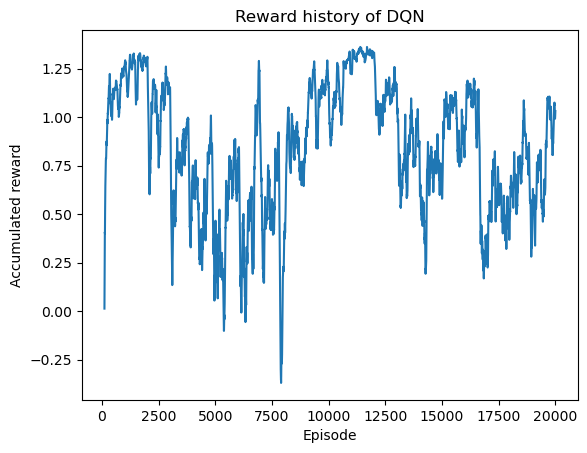

In [21]:
# save reward history
accumulated_rewards = pd.DataFrame(accumulated_rewards)
accumulated_rewards.to_csv('reward_history_gatten_iterate.csv', index=False)
# smooth the reward history
accumulated_rewards = accumulated_rewards.rolling(window=100).mean()
fig, ax = plt.subplots()
ax.plot(accumulated_rewards)
ax.set(xlabel='Episode', ylabel='Accumulated reward',
       title='Reward history of DQN')

In [14]:
def test():
    env.reset()
    accumulated_rewards = []
    done = False
    while not done:
        state = env.step()
        done = env.sim_done()
        accumulated_reward = 0
        routing_done = False
        while not routing_done:
            action_mask = env.get_action_mask()
            shuffle_indices = torch.tensor([0, 1, 2, 3, 4, 5])
            action, use_policy = select_action(state, action_mask, shuffle_indices)
            node_features, reward, routing_done = env.act(action.item())
            reward = torch.tensor([reward], device=device)
            accumulated_reward += reward.item()

            routing_done = routing_done

            if routing_done:
                next_state = None
            else:
                next_state = node_features

            # Move to the next state
            state = next_state
        accumulated_rewards.append(accumulated_reward)
    return accumulated_rewards

In [20]:
test_rewards = np.array(test())
# save the test rewards
np.save("test_rewards_gatten.npy", test_rewards)
print("Average test reward: ", np.mean(test_rewards))

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 107.25s
 TraCI-Duration: 0.01s
 Real time factor: 3.73889
 UPS: 79.439819
Vehicles: 
 Inserted: 45 (Loaded: 48)
 Running: 39
 Waiting: 0
Statistics (avg of 6):
 RouteLength: 1965.69
 Speed: 10.02
 Duration: 203.50
 WaitingTime: 1.83
 TimeLoss: 23.67
 DepartDelay: 0.35

 Retrying in 1 seconds
***Starting server on port 55117 ***
Loading net-file from './config/osm.net.xml.gz' ... done (113ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.


/tmp/ipykernel_4438/2174912558.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.state, torch.tensor(reward).to(device), self.routing_done


Average test reward:  -0.07594893354066938


In [15]:
n_nodes = 55
env = RoutingGym(sumoCmd, 1100, n_nodes, max_n_neighbors=6)
max_n_neighbors = 6

policy_net = SAGE_GDQN_Attention(n_nodes=n_nodes, max_n_neighbors=max_n_neighbors).to(device)
target_net = SAGE_GDQN_Attention(n_nodes=n_nodes, max_n_neighbors=max_n_neighbors).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(1000000)
steps_done = 0
accumulated_rewards = train()

 Retrying in 1 seconds
***Starting server on port 34209 ***
Loading net-file from './config/osm.net.xml.gz' ... done (113ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.


/tmp/ipykernel_4454/2174912558.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.state, torch.tensor(reward).to(device), self.routing_done


Step: 1, Iteration: 190, Accumulated reward: -4.850000157952309
Step: 2, Iteration: 190, Accumulated reward: 1.064285732805729
Step: 3, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 4, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 5, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 6, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 7, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 8, Iteration: 190, Accumulated reward: -0.4153846502304077
Step: 9, Iteration: 190, Accumulated reward: 1.0833333134651184
Step: 10, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 11, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 12, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 13, Iteration: 190, Accumulated reward: -5.35000017285347
Step: 14, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 15, Iteration: 190, Accumulated reward: 1.0833333134651184
Step: 16, Iteration: 190, Accumulat

[Text(0.5, 0, 'Episode'),
 Text(0, 0.5, 'Accumulated reward'),
 Text(0.5, 1.0, 'Reward history of DQN')]

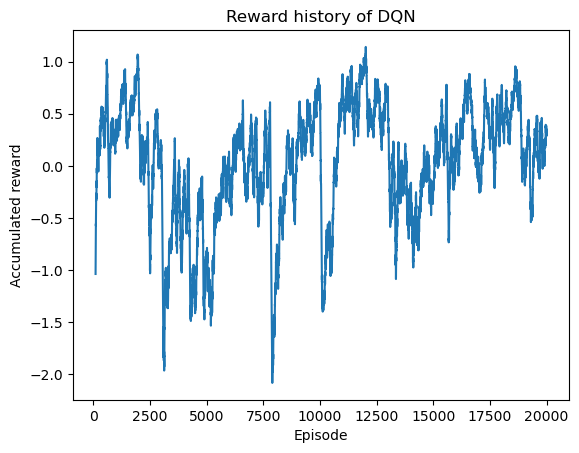

In [16]:
# save reward history
accumulated_rewards = pd.DataFrame(accumulated_rewards)
accumulated_rewards.to_csv('reward_history_sageatten_iterate.csv', index=False)
# smooth the reward history
accumulated_rewards = accumulated_rewards.rolling(window=100).mean()
fig, ax = plt.subplots()
ax.plot(accumulated_rewards)
ax.set(xlabel='Episode', ylabel='Accumulated reward',
       title='Reward history of DQN')

In [17]:
test_rewards = np.array(test())
# save the test rewards
np.save("test_rewards_sageatten.npy", test_rewards)
print("Average test reward: ", np.mean(test_rewards))

Simulation ended at time: 500.00
Reason: TraCI requested termination.
Performance: 
 Duration: 7413.64s
 TraCI-Duration: 7335.64s
 Real time factor: 0.0674433
 UPS: 1.706315
Vehicles: 
 Inserted: 55 (Loaded: 70)
 Running: 44
 Waiting: 0
Statistics (avg of 11):
 RouteLength: 2348.59
 Speed: 9.89
 Duration: 244.45
 WaitingTime: 5.91
 TimeLoss: 30.81
 DepartDelay: 0.41

 Retrying in 1 seconds
***Starting server on port 34995 ***
Loading net-file from './config/osm.net.xml.gz' ... done (106ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.


/tmp/ipykernel_4454/2174912558.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.state, torch.tensor(reward).to(device), self.routing_done


Average test reward:  0.5941651057924932


In [18]:
n_nodes = 55
env = RoutingGym(sumoCmd, 1100, n_nodes, max_n_neighbors=6)
max_n_neighbors = 6

policy_net = JK_SAGE_GDQN_Attention(n_nodes=n_nodes, max_n_neighbors=max_n_neighbors).to(device)
target_net = JK_SAGE_GDQN_Attention(n_nodes=n_nodes, max_n_neighbors=max_n_neighbors).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(1000000)
steps_done = 0
accumulated_rewards = train()

Simulation ended at time: 1101.00
Reason: TraCI requested termination.
Performance: 
 Duration: 27483.28s
 TraCI-Duration: 28.63s
 Real time factor: 0.0400607
 UPS: 1.484648
Vehicles: 
 Inserted: 89
 Running: 30
 Waiting: 0
Statistics (avg of 59):
 RouteLength: 4182.20
 Speed: 9.57
 Duration: 445.32
 WaitingTime: 15.56
 TimeLoss: 61.37
 DepartDelay: 0.48

 Retrying in 1 seconds
***Starting server on port 52337 ***
Loading net-file from './config/osm.net.xml.gz' ... done (107ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.


/tmp/ipykernel_4454/2174912558.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.state, torch.tensor(reward).to(device), self.routing_done


Step: 1, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 2, Iteration: 190, Accumulated reward: 1.064285732805729
Step: 3, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 4, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 5, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 6, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 7, Iteration: 190, Accumulated reward: 0.4833333268761635
Step: 8, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 9, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 10, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 11, Iteration: 190, Accumulated reward: 1.0833333134651184
Step: 12, Iteration: 190, Accumulated reward: -2.850000098347664
Step: 13, Iteration: 190, Accumulated reward: -1.4368421733379364
Step: 14, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 15, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 16, Iteration: 190, Accumula

[Text(0.5, 0, 'Episode'),
 Text(0, 0.5, 'Accumulated reward'),
 Text(0.5, 1.0, 'Reward history of DQN')]

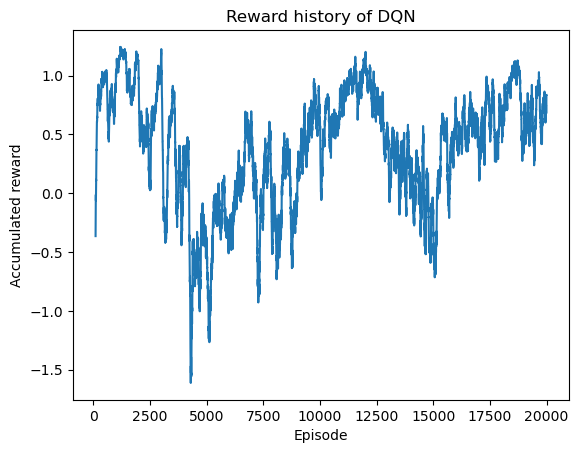

In [19]:
# save reward history
accumulated_rewards = pd.DataFrame(accumulated_rewards)
accumulated_rewards.to_csv('reward_history_jksageatten_iterate.csv', index=False)
# smooth the reward history
accumulated_rewards = accumulated_rewards.rolling(window=100).mean()
fig, ax = plt.subplots()
ax.plot(accumulated_rewards)
ax.set(xlabel='Episode', ylabel='Accumulated reward',
       title='Reward history of DQN')

In [20]:
test_rewards = np.array(test())
# save the test rewards
np.save("test_rewards_jksageatten.npy", test_rewards)
print("Average test reward: ", np.mean(test_rewards))

Simulation ended at time: 500.00
Reason: TraCI requested termination.
Performance: 
 Duration: 6430.67s
 TraCI-Duration: 6382.21s
 Real time factor: 0.0777524
 UPS: 1.967137
Vehicles: 
 Inserted: 55 (Loaded: 70)
 Running: 44
 Waiting: 0
Statistics (avg of 11):
 RouteLength: 2348.59
 Speed: 9.89
 Duration: 244.45
 WaitingTime: 5.91
 TimeLoss: 30.81
 DepartDelay: 0.41

 Retrying in 1 seconds
***Starting server on port 38015 ***
Loading net-file from './config/osm.net.xml.gz' ... done (99ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.


/tmp/ipykernel_4454/2174912558.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.state, torch.tensor(reward).to(device), self.routing_done


Average test reward:  0.8287991880732835
